In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
%matplotlib inline
import cv2
import time

## Step1: Image yolo_nba_detection

In [2]:
# Load Trained weights and model cfg
# set path for data names
nba_class_file = "trained_yolo/nba_detection.names"
# read nba_detection object names
LABELS = open(nba_class_file).read().strip().split("\n")
print('The dataset contains images of the following items: \n', LABELS)

# configure YOLOv3
# set paths to config files
yolov3_weight_file = "trained_yolo/yolov3_custom2_final.weights"
yolov3_config_file = "trained_yolo/yolov3.cfg"

# built YOLO network
net = cv2.dnn.readNetFromDarknet(yolov3_config_file, yolov3_weight_file)

# # print information about all layers in the YOLO v3 model
# # get all layer names in the network
# ln = net.getLayerNames()
# print("YOLO v3 has {} layers:".format(len(ln)))
# print(ln)
# # the output layers are those with unconnected output
# ln_out = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
# print("\nNames of YOLO v3 output layers: \n{}".format(ln_out))

The dataset contains images of the following items: 
 ['Player', 'Judge', 'Basketball', 'Empty_Basket_Left', 'Made_Basket_Left', 'Empty_Basket_Right', 'Made_Basket_Right']


In [3]:
# Image NBA Detection
def yolo_detect(model,image,vis_raw_img=False):
    '''READ IMAGE FILE'''
    # preprocess image data with rescaling and resizing, using RGB which is unusual for opencv
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), crop=False)
    # print('Format of blob: {}'.format(blob.shape))
    # we need to convert the blob in order to be able to show it
    blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
    # print('Format of blob_to_show: {}'.format(blob_to_show.shape))
    (h, w) = image.shape[:2]

    # visualize result of preprocessing
    if vis_raw_img:
        plt.figure(figsize = (6,6))
        plt.imshow(blob_to_show)
        plt.title('Resized Raw Image', size = 16)
        plt.show()

    '''MAKE PREDICTION'''
    ##### the actual inference #########
    ln = model.getLayerNames()
    ln_out = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
    # set a new input to the network
    model.setInput(blob)
    # mesasure the time needed for the object detection 
    start = time.time()
    layerOutputs = model.forward(ln_out)
    end = time.time()
    # Showing spent time for forward pass
    # print('YOLO v3 took {:.4f} seconds'.format(end - start))

    '''MODIFY LAYER OUTPUTS'''
    classes, scores, boxes = get_result(w,h,layerOutputs) 
    # Apply Non-max supression
    # print('we start with ', len(scores), 'indices')
    nms_idx = yolo_non_max_supression(boxes, scores, score_threshold=0.3, iou_threshold = 0.3)
    # print(len(nms_idx), 'indices are kept:', nms_idx)

    basket_label, basket_img = basket_extraction(image,nms_idx,classes,boxes)

    # '''VISUALIZE YOLOv3 DETECTED RESULTS'''
    # if vis: 
    #     result_img = vis_result(image,nms_idx,classes,scores,boxes)
    #     return result_img,detected_boxes,basket_img,basket_label

    return nms_idx, classes,scores,boxes,basket_img,basket_label
    
''' Function get_result:
    # - merges the three outputs 
    # - removes all empty bounding boxes (i.e. class_probability < threshold ), 
    # - rescales the bounding boxes
'''
def get_result(w,h,layerOutputs,probability_minimum = 0.4):
    # Preparing lists for detected bounding boxes, obtained confidences and class's number
    boxes = []
    scores = []
    classes = []
    # iterating through all three outputs
    for result in layerOutputs:
        # Going through all bounding boxes from current output layer
        for detection in result:
            # Getting class for current object
            scores_current = detection[5:]
            class_current = np.argmax(scores_current)
            # Getting probability for current object
            probability_current = scores_current[class_current]
            # Getting object confidence for current object
            object_confidence = detection[4]
            # Eliminating weak predictions by minimum probability
            if probability_current > probability_minimum:
            #if probability_current*object_confidence > probability_minimum:  # this is an alternative way
                # Scaling bounding box coordinates to the initial image size
                # by elementwise multiplying them with the width and height of the image
                box_current = np.array(detection[0:4]) * np.array([w, h, w, h])
                # YOLO data format keeps center of detected box and its width and height
                # here we reconstruct the top left and bottom right corner
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))
                x_max = int(x_center + (box_width / 2))
                y_max = int(y_center + (box_height / 2))

                # Adding results into prepared lists
                boxes.append([x_min, y_min, x_max, y_max])
                scores.append(float(probability_current))
                classes.append(class_current)
                
    return np.array(classes), np.array(scores), np.array(boxes)


''' Function basket_extraction:
    # - Given Yolo's result, extract the detected basket image
'''

def basket_extraction(img,box_indice,classes,boxes):
    def pt_map(pt): # make sure positive
        if pt < 0: return 0
        else: return pt
    # plt.imshow(img)
    for box in box_indice:
        if LABELS[classes[box]] in ['Empty_Basket_Left', 'Made_Basket_Left', 'Empty_Basket_Right', 'Made_Basket_Right']:
            pt1_x, pt1_y = int(boxes[box, 0]), int(boxes[box, 1])
            pt2_x, pt2_y = int(boxes[box, 2]), int(boxes[box, 3])
            pt1_x, pt1_y, pt2_x, pt2_y = pt_map(pt1_x),pt_map(pt1_y),pt_map(pt2_x),pt_map(pt2_y)
            return LABELS[classes[box]], img[pt1_y:pt2_y+1,pt1_x:pt2_x+1,:].copy()
    return 'Fail_Detecting_Basket',None


'''
Function vis_result: 
    # - Draw bounding boxes on the image and show
    # - parameters bounding box
    # - assign rondom colours to the class labels, these are used to draw the bounding boxes
'''
    
def vis_result(image,box_indice,classes,scores,boxes,vis=False):
    # determine image size -> will be needed to rescale bounding boxes
    (h, w) = image.shape[:2]
    np.random.seed(45)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    border_thickness = 2
    # parameters text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    text_thickness = 2
    text_offset_x = 7
    text_offset_y = 7
    for box in box_indice:
        # draw the bounding box
        color = tuple([int(c) for c in COLORS[classes[box]]])

        (pt1_x, pt1_y) = (int(boxes[box, 0]), int(boxes[box, 1]))
        (pt2_x, pt2_y) = (int(boxes[box, 2]), int(boxes[box, 3]))
        
        cv2.rectangle(image, (pt1_x, pt1_y), (pt2_x, pt2_y), color, border_thickness)
        
        # print the label
        text = "{}: {:.4f}".format(LABELS[classes[box]], scores[box])
        (t_w, t_h), _ = cv2.getTextSize(text, font, fontScale=font_scale, thickness=text_thickness)
        (text_box_x1, text_box_y1) = (pt1_x, pt1_y - (t_h + text_offset_y))
        (test_box_x2, text_box_y2) = ((pt1_x + t_w + text_offset_x), pt1_y)
        
        cv2.rectangle(image, (text_box_x1, text_box_y1), (test_box_x2, text_box_y2), color, cv2.FILLED)   
        cv2.putText(image, text, (pt1_x + text_offset_x,pt1_y - 5), font, font_scale, 
                                    (255, 255, 255), text_thickness)
    if vis:
        plt.figure(figsize=(w*0.05, h*0.05))
        plt.title('YOLOv3_Detected Image',size=80)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    return image

'''
Function yolo_non_max_supression:
    # - Apply Non-Max Supression
    # - Remove overlapping boxes
'''

def yolo_non_max_supression(boxes, scores, score_threshold=0.5, iou_threshold=0.3):

    #  Apply Non-max supression.
    #    boxes : Array of coordinates of boxes (x1, y1, x2, y2)
    #    scores : Array of confidence scores with respect to boxes
    #    score_threshold : Threshold, higher will be kept
    #    iou_threshold : if iou is below threshold, keep both boxes
    #    Return : Indices of boxes and scores to be kept

    def iou(box1, box2):
        # Caculate IoU between box1 and box2
        #    box1/box2 : (x1, y1, x2, y2), where x1 and y1 are coordinates of upper left corner, 
        #                x2 and y2 are of lower right corner
        #    return: IoU
        
        # get the area of intersection 
        # top left corner
        xi1 = max(box1[0], box2[0])
        yi1 = max(box1[1], box2[1])
        # bottom right corner
        xi2 = min(box1[2], box2[2])
        yi2 = min(box1[3], box2[3])

        # max answers questioon: is there and intersection at all
        inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
        
        # get the area of union
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        
        union_area = box1_area + box2_area - inter_area
        
        # get iou
        iou = inter_area / union_area
        
        return iou
    
    sorted_idx = np.argsort(scores)[::-1]
    
    remove = []
    for i in np.arange(len(scores)):
        if i in remove:   # already processed
            continue
        if scores[sorted_idx[i]] < score_threshold:   # score below threshold?
            remove.append(i)
            continue
            
        for j in np.arange(i+1, len(scores)):     # go through remaining boxes of list
            if scores[sorted_idx[j]] < score_threshold:
                remove.append(j)
                continue    
            overlap = iou(boxes[sorted_idx[i]], boxes[sorted_idx[j]])
            if overlap > iou_threshold:   # remove second box, which has smaller score due to sorting
                remove.append(j)
                
    sorted_idx = np.delete(sorted_idx, remove)  # clean the list

    return sorted(sorted_idx)

def bgr2rgb(cvimg):
    return np.dstack((cvimg[:,:,2],cvimg[:,:,1],cvimg[:,:,0]))
def rgb2bgr(img):
    return np.dstack((img[:,:,2],img[:,:,1],img[:,:,0]))

In [4]:
# Test Performance of RAW Yolo
import os
class_dir = ['LE','LM','RE','RM']
overall_c,overall = 0,0 
for i in range(len(class_dir)):
    label = class_dir[i]
    data = os.listdir('Test_Set/'+ label)
    correct_c = 0
    for pic in data:
        path = 'Test_Set/'+ label + '/' + pic
        image = bgr2rgb(cv2.imread(path))
        nms_idx, classes,scores,boxes,basket_img,basket_label = yolo_detect(model=net,image=image,vis_raw_img=False)
        if basket_label == LABELS[i+3]: correct_c+=1
        # print(basket_label)
    overall_c += correct_c
    overall += len(data)
    print("Result for Class {}: {}/{} accuracy is {}".format(label,correct_c,len(data),round(correct_c/len(data),3)))
print("Result for {} test images: {}/{} accuracy is {}".format(overall,overall_c,overall,round(overall_c/overall,3)))

Result for Class LE: 1/10 accuracy is 0.1
Result for Class LM: 0/15 accuracy is 0.0
Result for Class RE: 4/10 accuracy is 0.4
Result for Class RM: 6/15 accuracy is 0.4
Result for 50 test images: 11/50 accuracy is 0.22


# Step2: Train an CNN to classify Left_Basket/Right_Basket

In [5]:
# Do this because we found that Yolo mostly mistake between left/right basket
import os   # file operations
from tensorflow.keras import layers
from tensorflow.keras import Model

In [9]:
CNN_LABELS = ['Left_Basket','Right_Basket']

def canny_filter(img): # apply canny filter on basket img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges_img = cv2.Canny(gray_img,50,300)
    return edges_img


def build_dataset(preprocess,Set): # store data in numpy format
    X,y = [],[]
    for label in CNN_LABELS:
        base_dir = 'cnn_basket_detection_data/' + Set + '/' + label
        for data in os.listdir(base_dir):
            path = base_dir + '/' + data
            # print(path)
            img = cv2.imread(path)
            img = cv2.resize(img,(100,100),dst=True,interpolation=cv2.INTER_AREA) # resize
            if preprocess == 'canny': img = canny_filter(img) # apply filter
            X.append(img.flatten())
            y.append(CNN_LABELS.index(label))
    X = np.array(X)
    y = np.array(y)
    return X,y

X_train,y_train = build_dataset("canny","Train_Set")
X_val,y_val = build_dataset("canny","Val_Set")

In [10]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
img_rows, img_cols = 100, 100
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
print(X_train.shape)
print(X_val.shape)

(250, 10000) (250,)
(49, 10000) (49,)
(250, 100, 100, 1)
(49, 100, 100, 1)


In [11]:
# build the CNN network
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K

# use sequential api


model = Sequential()

# input shape: 100*100
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                    input_shape=(100,100,1))) 
                 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 flatten (Flatten)           (None, 33856)             0

2022-05-10 19:17:38.305388: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
from tensorflow.keras.optimizers import Adam

# compile the model with loss function, optimizer, evaluation metrics
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

# set batch and epoch
batch_size = 12
epochs = 100

# train the model
# history = model.fit(X_train, y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(X_val, y_val))

# save the weights
# model.save_weights('Left_Right_Classifier.h5')

model.load_weights('Left_Right_Classifier.h5')

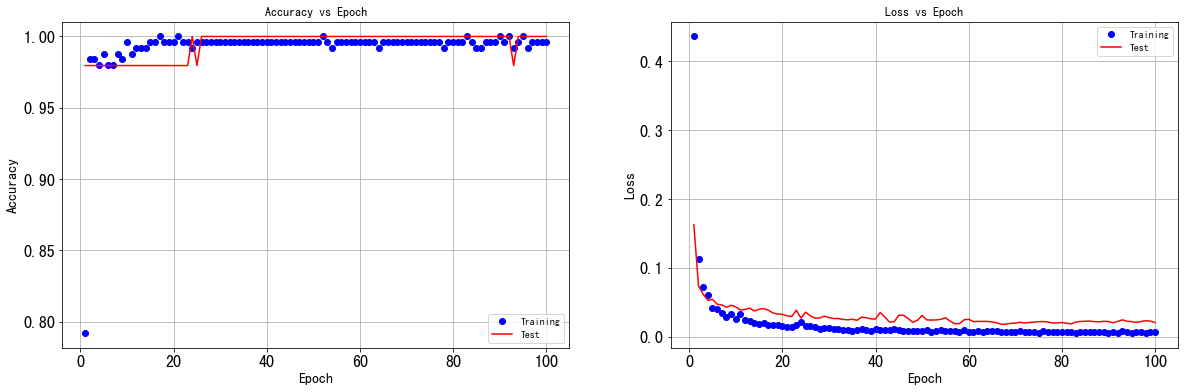

In [543]:
# (b) show the learning process (training & testing accuracy and loss)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.title("Accuracy vs Epoch")
plt.plot(epochs, accuracy, 'bo', label='Training')
plt.plot(epochs, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss vs Epoch")
plt.plot(epochs, loss, 'bo', label='Training')
plt.plot(epochs, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=14)
plt.ylabel('Loss', size=14)
plt.legend()
plt.grid()

plt.show()

In [13]:
from keras.preprocessing import image

# The Left-Right Classifier Prediction Function
def predict(img): 
    img = cv2.resize(img,(100,100),dst=True,interpolation=cv2.INTER_AREA) # resize
    img = canny_filter(img) # apply filter
    img = np.expand_dims(img,axis=0)
    p_result = model.predict(img)
    if p_result < 0.5: label = 'Left_Basket'
    else: label = 'Right_Basket'
    return label

In [14]:
# Now Merge both models to make final prediction
def made_basket_detection(image):
    box_idx,classes,scores,boxes,basket_img,basket_label = yolo_detect(model=net,image=image,vis_raw_img=False)
    

    # if yolo fails to detect basket, return Fail_Detecting_Basket
    if basket_label == 'Fail_Detecting_Basket': 
        return box_idx,classes,scores,boxes,basket_label 
    if basket_img is None:
        return box_idx,classes,scores,boxes,basket_label
        
    def correct_yolo(basket_label,basket_correct): # correct the yolo's result 
        for box in box_idx:
            if LABELS[classes[box]] == basket_label:
                classes[box] = LABELS.index(basket_correct)

    ## Re-identify the basket (Left or Right)
    label = predict(rgb2bgr(basket_img)) 
    if label =='Left_Basket':
        if basket_label in ['Empty_Basket_Left', 'Made_Basket_Left']:
            basket_correct =  basket_label
        elif basket_label in ['Empty_Basket_Right', 'Made_Basket_Right']:
            basket_correct =  basket_label[:-5] + 'Left'
            correct_yolo(basket_label,basket_correct) # correct the Class Labels
    elif label == 'Right_Basket':
        if basket_label in ['Empty_Basket_Left', 'Made_Basket_Left']:
            basket_correct = basket_label[:-4] + 'Right'
            correct_yolo(basket_label,basket_correct) # correct the Class Labels
        elif basket_label in ['Empty_Basket_Right', 'Made_Basket_Right']:
            basket_correct = basket_label

    return box_idx,classes,scores,boxes,basket_correct


In [15]:
# Test Performance of the Final Merged Model
import os
class_dir = ['LE','LM','RE','RM']
overall_c,overall = 0,0 
for i in range(len(class_dir)):
    label = class_dir[i]
    data = os.listdir('Test_Set/'+ label)
    correct_c = 0
    for pic in data:
        path = 'Test_Set/'+ label + '/' + pic
        image = bgr2rgb(cv2.imread(path))
        box_idx,classes,scores,boxes,basket_correct = made_basket_detection(image)
        if basket_correct == LABELS[i+3]: correct_c+=1
        # print(basket_correct)
    overall_c += correct_c
    overall += len(data)
    print("Result for Class {}: {}/{} accuracy is {}".format(label,correct_c,len(data),round(correct_c/len(data),3)))
print("Result for {} test images: {}/{} accuracy is {}".format(overall,overall_c,overall,round(overall_c/overall,3)))

Result for Class LE: 9/10 accuracy is 0.9
Result for Class LM: 8/15 accuracy is 0.533
Result for Class RE: 8/10 accuracy is 0.8
Result for Class RM: 6/15 accuracy is 0.4
Result for 50 test images: 31/50 accuracy is 0.62


Test Result Visualize:

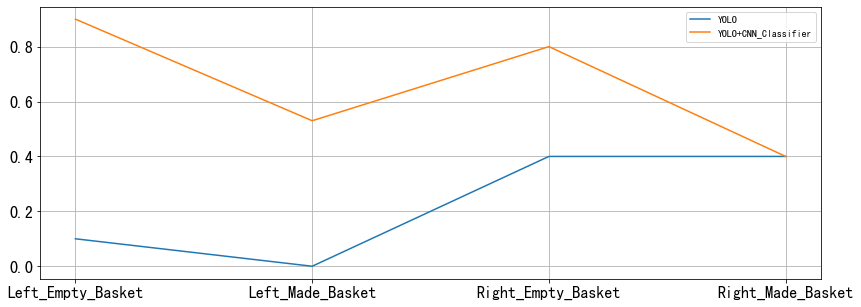

In [16]:
x = ['Left_Empty_Basket','Left_Made_Basket','Right_Empty_Basket','Right_Made_Basket']
plt.figure(figsize=(14,5))
plt.plot(x,[0.1,0.0,0.4,0.4],label='YOLO')
plt.plot(x,[0.9,0.53,0.8,0.4],label='YOLO+CNN_Classifier')
plt.legend()
plt.grid()

# Step3: Video nba_yolo_detection

In [17]:
video_path = "/Users/tracy/Desktop/CS302/Final Project/VideoGames/Lakers_Nuggets.mkv"
# video_path = "/Users/tracy/Desktop/CS302/Final Project/VideoGames/Nets_Warriors.mp4"
cap = cv2.VideoCapture(video_path)               # read the video
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))       # read the frame width
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))      # read the frame height
                            
print("Frame Length of the Video: {}".format(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

import progressbar
widgets = ["Finished Frames: ", progressbar.Percentage()," ", progressbar.Bar(), " ", progressbar.ETA()]

def video_nba_detection(video_cap,start,end,live_display=False):
    assert start < end
    writer = cv2.VideoWriter('Detected_VideoGames/frame{}to{}.mp4'.format(start,end), 
                                cv2.VideoWriter_fourcc(*'mp4v'), 30, (w, h))
    pbar = progressbar.ProgressBar(maxval=end-start+1, widgets=widgets).start() # progress bar
    basket_tracking = [] # basket status history
    Lakers_count, Nuggets_count = 0,0 # record for both teams
    making_basket = False # current basket status

    for i in range(start,end+1): 
        video_cap.set(cv2.CAP_PROP_POS_FRAMES,i)
        ret, bgrframe = video_cap.read()
        image = bgr2rgb(bgrframe) # read each image
        
        box_idx,classes,scores,boxes,basket_correct = made_basket_detection(image) # model detection
        basket_tracking.append(basket_correct)    #Record the basket status
        result_img = vis_result(image,box_idx,classes,scores,boxes) # draw resulting boxes

        # Draw Boxes for displaying 
        result_img = cv2.rectangle(result_img,(result_img.shape[1]//2-900,0),
                                   (result_img.shape[1]//2-400,100),color=(255,255,255),thickness=8)
        result_img = cv2.rectangle(result_img,(result_img.shape[1]//2+400,0),
                                   (result_img.shape[1]//2+900,100),color=(255,255,255),thickness=8)
        
        # Customized_RULE_Based Counter
        if i-start >= 10: # compute score since the 10th frame
            if making_basket: # if the basket is being made
                # DETECT if the BALL is LEAVING the Basket
                empty_count = 0
                for status in basket_tracking[-5:]:
                    if status in ['Empty_Basket_Left','Empty_Basket_Right']: empty_count +=1
                if empty_count >=3 and basket_correct in ['Empty_Basket_Left','Empty_Basket_Right']:
                    making_basket = False
            else: # if the basket is not being made
                # DETECT if the BALL is GOing INSIDE the Basket
                if (basket_correct in ['Made_Basket_Left','Made_Basket_Right']):
                    left_made_count, right_made_count = 0, 0
                    for status in basket_tracking[-6:]: 
                        if status == 'Made_Basket_Left': left_made_count +=1
                        elif status == 'Made_Basket_Right': right_made_count +=1
                        else: continue
                    if left_made_count+right_made_count >= 4: # basket side == max(#left,#right)
                        making_basket = True
                        if left_made_count > right_made_count: Nuggets_count+=1
                        else: Lakers_count += 1

        # write down the counts for teams
        result_img = cv2.putText(result_img, 'Lakers:{}'.format(Lakers_count), 
                                (result_img.shape[1]//2-880,50), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255, 255, 255), 8)
        result_img = cv2.putText(result_img, 'Nuggets:{}'.format(Nuggets_count), 
                                (result_img.shape[1]//2+420,50), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255, 255, 255), 8)

        # display the video with cv2.imshow
        result_img = rgb2bgr(result_img)
        if live_display:
            cv2.imshow('frame',result_img)
            k = cv2.waitKey(25)     # keep each img 25 ms
            if k == 27: break       # stop criteria: press ESC
            
        # write into the video
        writer.write(result_img)     
        pbar.update(i+1-start)
    pbar.finish()
    writer.release()
    if live_display: cv2.destroyAllWindows()

Frame Length of the Video: 162393.0


Test some Segments in the test video Lakers_vs_Nuggets

In [653]:
video_nba_detection(cap,start=14000,end=17500,live_display=True)

Finished Frames: 100% |#########################################| Time: 0:33:56


In [540]:
video_nba_detection(cap,start=4800,end=4850,live_display=True)

Finished Frames: 100% |#########################################| Time: 0:00:30
